<img src="https://s3.amazonaws.com/datascienceheroes.com/EDV/360_banner_python.png" width="400px">


# Escuela de Datos Vivos 

## LAB P.G.4.1: Clasificación multiclase
Creado por Pablo Casas | https://escueladedatosvivos.ai    

Creado por Pablo Sotomayor

---

## Ejercicios

En medicina, el atributo "talasemia" es un trastorno sanguíneo hereditario que hace que el cuerpo tenga menos hemoglobina de lo normal. La hemoglobina permite que los glóbulos rojos transporten oxígeno. La talasemia puede causar anemia.

Hacer: Cargar los datos de `heart_disease` y predecir la variable `thal` la cual es categórica, puede tomar los valores `3`, `6` ó `7`.

Crear las curvas de validación, usando como siempre un set de datos de entrenamiento y otro de validación.

In [1]:
# Librerías que vamos a utilizar

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars

warnings.filterwarnings('ignore')
%matplotlib inline
set_config(display='diagram') 

/home/pablo/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Carga de datos 

In [2]:
data = pd.read_csv("../data/heart_disease.csv", sep=",")

print(f"Cantidad de registros: {data.shape[0]}")
print(f"Cantidad de variables: {data.shape[1]}")

Cantidad de registros: 303
Cantidad de variables: 16


Inspeccionamos los datos elegiendo una muestra al azar

In [3]:
data.head()

,age,gender,chest_pain,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electro,max_heart_rate,exer_angina,oldpeak,slope,num_vessels_flour,thal,heart_disease_severity,exter_angina,has_heart_disease
0,63,male,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0,no
1,67,male,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,1,yes
2,67,male,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1,yes
3,37,male,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,0,no
4,41,female,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,0,no


Revisamos el estado de los datos

In [4]:
print(f"Cantidad de variables numéricas: {len(num_vars(data))}")
print(f"Cantidad de variables categóricas: {len(cat_vars(data))}")
status(data).sort_values(by=["p_nan", "p_zeros", "unique"], ascending=False)

Cantidad de variables numéricas: 14
Cantidad de variables categóricas: 2


,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
11,num_vessels_flour,4,0.013201,176,0.580858,4,float64
12,thal,2,0.006601,0,0.000000,3,float64
5,fasting_blood_sugar,0,0.000000,258,0.851485,2,int64
8,exer_angina,0,0.000000,204,0.673267,2,int64
14,exter_angina,0,0.000000,204,0.673267,2,int64
13,heart_disease_severity,0,0.000000,164,0.541254,5,int64
6,resting_electro,0,0.000000,151,0.498350,3,int64
9,oldpeak,0,0.000000,99,0.326733,40,float64
4,serum_cholestoral,0,0.000000,0,0.000000,152,int64
7,max_heart_rate,0,0.000000,0,0.000000,91,int64


Tenemos 14 variables declaradas como numéricas y 2 como categóricas. Las variables numéricas "num_vessels_flour" y "thal" tienen valores nulos (1% y 0.7% del total, respectivamente). La variable numérica "thal" está mal declarada, debe ser categórica. Lo mismo para las variables "fasting_blood_sugar", "exer_angina", "exter_angina", "heart_disease_severity", "resting_electro", "chest_pain", "slope".

Transformamos las variables mal declaradas

In [5]:
data["thal_cat"] = data["thal"].astype("str")
data["fasting_blood_sugar_cat"] = data["fasting_blood_sugar"].astype("str")
data["exer_angina_cat"] = data["exer_angina"].astype("str")
data["exter_angina_cat"] = data["exter_angina"].astype("str")
data["heart_disease_severity_cat"] = data["heart_disease_severity"].astype("str")
data["resting_electro_cat"] = data["resting_electro"].astype("str")
data["chest_pain_cat"] = data["chest_pain"].astype("str")
data["slope_cat"] = data["slope"].astype("str")

Eliminamos las variables mal declaradas

In [6]:
variables = ["thal", "fasting_blood_sugar", "exer_angina", "exter_angina", "heart_disease_severity", "resting_electro", \
             "chest_pain", "slope"]

data = data.drop(variables, axis=1)

In [7]:
status(data).sort_values(by=["type"], ascending=False)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
1,gender,0,0.000000,0,0.000000,2,object
7,has_heart_disease,0,0.000000,0,0.000000,2,object
8,thal_cat,0,0.000000,0,0.000000,4,object
9,fasting_blood_sugar_cat,0,0.000000,0,0.000000,2,object
10,exer_angina_cat,0,0.000000,0,0.000000,2,object
11,exter_angina_cat,0,0.000000,0,0.000000,2,object
12,heart_disease_severity_cat,0,0.000000,0,0.000000,5,object
13,resting_electro_cat,0,0.000000,0,0.000000,3,object
14,chest_pain_cat,0,0.000000,0,0.000000,4,object
15,slope_cat,0,0.000000,0,0.000000,3,object


Exploramos los registros con datos nulos para "thal_cat

In [8]:
data[data["thal_cat"] == "nan"]

,age,gender,resting_blood_pressure,serum_cholestoral,max_heart_rate,oldpeak,num_vessels_flour,has_heart_disease,thal_cat,fasting_blood_sugar_cat,exer_angina_cat,exter_angina_cat,heart_disease_severity_cat,resting_electro_cat,chest_pain_cat,slope_cat
87,53,female,128,216,115,0.0,0.0,no,nan,0,0,0,0,2,3,1
266,52,male,128,204,156,1.0,0.0,yes,nan,1,1,1,2,0,4,2


Eliminamos los 2 registros con 'thal' == 'nan'

In [9]:
data = data[data['thal_cat'] != 'nan']

Dividimos los datos en TR y TS

In [10]:
data_x = data.drop("thal_cat", axis=1)
data_y = data["thal_cat"]

x_tr, x_ts, y_tr, y_ts = train_test_split(data_x, 
                                          data_y, 
                                          test_size=0.2, 
                                          random_state=0)

Creamos un Pipeline para las variables numéricas y otra para las categóricas y juntamos todo en otro Pipeline

In [11]:
num_transformer = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='median'))])

cat_transformer = Pipeline(
    steps=[('cat_imputer', SimpleImputer(strategy='constant', fill_value='nulo')),
          ('ohe', OneHotEncoder())])

all_transformer = ColumnTransformer(
    transformers=[
        ('num_t', num_transformer, num_vars(x_tr)),
        ('cat_t', cat_transformer, cat_vars(x_tr))])

In [12]:
all_transformer

ColumnTransformer(transformers=[('num_t',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['age', 'resting_blood_pressure', 'serum_cholestoral', 'max_heart_rate',
       'oldpeak', 'num_vessels_flour'],
      dtype='object')),
                                ('cat_t',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='nulo',
                                                                strategy='constant')),
                                                 ('ohe', OneHotEncoder())]),
                                 Index(['gender', 'has_heart_disease', 'fasting_blood_sugar_cat',
       'exer_angina_cat', 'exter_angina_cat', 'heart_disease_severity_cat',
       'resting_electro_cat', 'chest_pain_cat', 'slope_cat'],
      dtype='object'))])

Creación del modelo

In [13]:
pipe_rf = Pipeline(steps=[('all_transformer', all_transformer),
                          ('model_rf', RandomForestClassifier(
                              n_estimators=100,
                              min_samples_leaf=40,                               
                              max_depth=5,
                              min_samples_split=40))])

pipe_rf.fit(x_tr, y_tr)

Pipeline(steps=[('all_transformer',
                 ColumnTransformer(transformers=[('num_t',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['age', 'resting_blood_pressure', 'serum_cholestoral', 'max_heart_rate',
       'oldpeak', 'num_vessels_flour'],
      dtype='object')),
                                                 ('cat_t',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='nulo',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'has_heart_disease', 'fasting_blood_sugar_cat',
       'exer_angina_cat', 'exter_angina_cat', 'heart_disease_severity_cat',
       'resting_electro_cat', 'chest_pain_cat', 'slope_cat'],
      dtype='object'))])),
                ('model_rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=40,
                                        min_samples_split=40))])

Curvas de validación

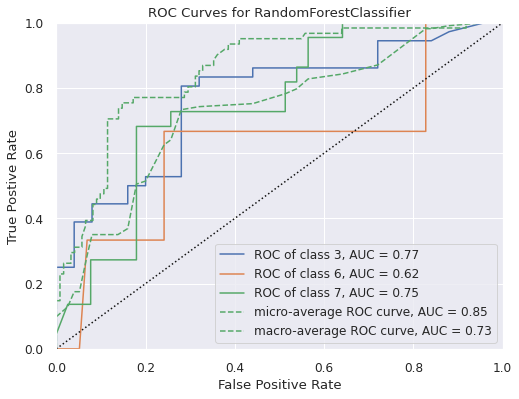

In [14]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.1)

visualizer = ROCAUC(pipe_rf, classes=["3", "6", "7"])

visualizer.fit(x_tr, y_tr)        # Fit the training data to the visualizer
visualizer.score(x_ts, y_ts)        # Evaluate the model on the test data
visualizer.show() 
plt.show()

La diferencia entre macro y micro average ROC curve, es que macro pesa cada clase por igual, mientras que micro pesa cada muestra por igual.

Generamos el reporte de clasificación

In [15]:
y_pred_tr = pipe_rf.predict(x_tr)
y_pred_ts = pipe_rf.predict(x_ts)

In [16]:
print(classification_report(y_tr, y_pred_tr))
print(classification_report(y_ts, y_pred_ts))

              precision    recall  f1-score   support

         3.0       0.78      0.86      0.82       130
         6.0       0.00      0.00      0.00        15
         7.0       0.71      0.72      0.71        95

    accuracy                           0.75       240
   macro avg       0.50      0.53      0.51       240
weighted avg       0.70      0.75      0.72       240

              precision    recall  f1-score   support

         3.0       0.80      0.78      0.79        36
         6.0       0.00      0.00      0.00         3
         7.0       0.62      0.73      0.67        22

    accuracy                           0.72        61
   macro avg       0.47      0.50      0.49        61
weighted avg       0.69      0.72      0.71        61



In [17]:
data["thal_cat"].value_counts()

3.0    166
7.0    117
6.0     18
Name: thal_cat, dtype: int64

Vemos que hay un problema de desbalance de clases que debe ser corregido (próximo laboratorio).